<a href="https://colab.research.google.com/github/MarioBolanos/Modelado-y-Simulacion/blob/master/7_Complex_Systems/MC_SIR_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic SIR model for epidemiology - Agents modeling approach

Given a set of $N$ people, the objective is to predict the behaviour of a contagious disease that is spreading over the population, that is, forecast the size of the infectious population in every time instanct.

For that matter, we will assume the most basic epidemiological model, the SIR model. Assume that at any point in time, each person can be in either of these 3 states: 

**S (Susceptible):** Healthy, but could get infected in the future.

**I (Infectious):** Already caught the disease and is currently capable of transmitting it to the susceptible population.

**R (Recovered):** Already had the disease and recovered from it, can't transmit the disease and achieved long-term immunity.

The following image shows the possible state transitions for any individual:

<img src="https://github.com/ccgalindog/Modeling_and_Simulation/blob/master/In_Class/sir.png?raw=1">

- An $S$ individual that has an interaction with an *I* individual has a probability $\beta$ to get infected, thus undorgoing a transition $S \rightarrow I$.

- An $I$ individual has a fixed probability $\gamma$ to recover from the disease at any time instact, thus going through the $I \rightarrow R$ state transition.

- Aiming for simplicity, $R$ individuals do not go through any state transition, they become immune to the disease forever.



### Imports

In [ ]:
import networkx as nx
import numpy as np
from matplotlib import style as mpst
mpst.use('classic')
from matplotlib import pyplot as plt
from time import time, sleep
from IPython import display
from collections import Counter

### Define the Agents

Each agent will represent a person, with the following description:

**Properties:**

- *health_state:* Feature that indicates the current state of the person (either S, I or R).

**Methods:**

- *change_state:* Replace the health state of the person.

- *get_infected_neighbours:* Return the number of infectious agents that are in contact with this person.

In [ ]:
class SomePerson():
    def __init__( self, health_state ):
        self.health_state = health_state
    
    def change_state( self, new_state ):
        self.health_state = new_state
        
    def get_infected_neighbours( self, G, own_index, all_people ):
        neighbors = list( G.neighbors( own_index ) )
        num_infected_nbhs = len([all_people[ nb_index ].health_state for nb_index in neighbors\
                         if all_people[ nb_index ].health_state == 'I'])

        return num_infected_nbhs

### Define the simulation logic

1. Given a list of agents and a graph $G$ representing the interactions between them, check the distribution of $S$, $I$ and $R$ people. 
2. For each agent, check its state:

    2.a. If the agent is $S$, check how many $I$ agents surround it. For each infectious neighbour draw a random number $\nu$ from an uniform distribution. If at least one $\nu < \beta$ then this agent must get infected at the end of the iteration.
    
    2.b. If the agent is $I$, draw a random number $\xi$ from an uniform distribution, if $\xi < \gamma$ then this agent must recover at the end of the iteration.
    
3. Change the state $S \rightarrow I$ and $I \rightarrow R$ for all the required agents.

4. Return to step 1 until no $I$ agents exist or a maximum number of iterations is reached.


In [ ]:
def run_MC_SIR( G, all_people, N, max_iter, beta_val, gamma_val, colors_dict, to_plot ):
    # Count how many S, I and R people are there in the population:
    count_states = Counter([ person.health_state for person in all_people ])
    S_size = [ 100*count_states['S']/N ]
    I_size = [ 100*count_states['I']/N ]
    R_size = [ 100*count_states['R']/N ]
    t = 0
    while ( t <  max_iter ) and (I_size[-1] > 0):
        # Draw the current state of the population:
        if to_plot:
            draw_city( all_people, colors_dict, G, N )
            display.clear_output(wait=True)
            display.display(plt.gcf())
            sleep(1)

        these_get_sick = []
        these_get_well = []

        for i in range( N ):

            if (all_people[i].health_state == 'S'): #Check if this S person has I neighbours:
                number_infecs = all_people[i].get_infected_neighbours( G, i, all_people )

                for each_infected_link in range(number_infecs): 
                    #This S person 'interacts' with those I agents and has a chance to get sick:
                    if (np.random.rand() < beta_val):
                        these_get_sick.append( i )

            elif (all_people[i].health_state == 'I'):
                #This I person has a chance to recover from the disease
                if (np.random.rand() < gamma_val):
                    these_get_well.append( i )

        #After checkinfg the whole population, change the states of the agents:
        for j in these_get_sick:
            all_people[j].change_state( 'I' )

        for k in these_get_well:
            all_people[k].change_state( 'R' )

        count_states = Counter([ person.health_state for person in all_people ])
        S_size.append( 100*count_states['S']/N )
        I_size.append( 100*count_states['I']/N )
        R_size.append( 100*count_states['R']/N )
        t = t + 1
        
    return S_size, I_size, R_size

### Drawing functions

In [ ]:
def draw_city( all_people, colors_dict, G, N ):
    
    all_colors = [ colors_dict[ all_people[i].health_state ] for i in range(N) ]

    plt.figure()
    nx.draw( G, nx.spring_layout( G, seed = 0 ), node_size = 50,
         node_color = all_colors )

def draw_timeline( S_size, I_size, R_size, colors_dict ):
    plt.figure( figsize = (6, 4) )
    plt.plot( S_size, color = colors_dict['S'], label = r'$S$', ms = 5, marker = 'o' ) 
    plt.plot( I_size, color = colors_dict['I'], label = r'$I$', ms = 5, marker = 'o' ) 
    plt.plot( R_size, color = colors_dict['R'], label = r'$R$', ms = 5, marker = 'o' ) 
    plt.ylabel( 'Fraction of the population [%]' )
    plt.xlabel( 'Time steps' )
    plt.grid()
    plt.legend(loc = 7)
    
    
def plot_errorbars( all_results_S, all_results_I, all_results_R, colors_dict ):
    max_result_size = np.max([len(a_list) for a_list in all_results_S])

    clean_results_S = np.array([np.pad( np.array(res_vec), (0, max_result_size - len( res_vec ) ),
           mode = 'constant', constant_values = np.nan ) for res_vec in all_results_S])
    
    clean_results_I = np.array([np.pad( np.array(res_vec), (0, max_result_size - len( res_vec ) ),
           mode = 'constant', constant_values = np.nan ) for res_vec in all_results_I])
        
    clean_results_R = np.array([np.pad( np.array(res_vec), (0, max_result_size - len( res_vec ) ),
           mode = 'constant', constant_values = np.nan ) for res_vec in all_results_R])

    plt.figure( figsize = (6,4) )
    plt.errorbar( np.arange(0, max_result_size), np.nanmean( clean_results_S, axis = 0 ),
                 yerr = np.nanstd( clean_results_S, axis = 0 ),
                linewidth = 1.5, ms = 3, marker = 'd',
                 color = colors_dict['S'], label = 'S')
    plt.errorbar( np.arange(0, max_result_size), np.nanmean( clean_results_I, axis = 0 ),
                 yerr = np.nanstd( clean_results_I, axis = 0 ),
                linewidth = 1.5, ms = 3, marker = 'd',
                 color = colors_dict['I'], label = 'I')
    plt.errorbar( np.arange(0, max_result_size), np.nanmean( clean_results_R, axis = 0 ),
                 yerr = np.nanstd( clean_results_R, axis = 0 ),
                linewidth = 1.5, ms = 3, marker = 'd',
                 color = colors_dict['R'], label = 'R')
    plt.ylim([0,100])
    plt.legend(loc=4)
    plt.ylabel( 'Fraction of the population [%]' )
    plt.xlabel( 'Time steps' )
    plt.grid()
    

### Set simulation parameters

In [ ]:
name_states = ['S', 'I', 'R']
colors_dict = { 'S' : 'navy', 'I' : 'crimson', 'R' : 'limegreen' }
max_iter = 100
N = 100
all_people = []
beta_val = 0.3 # Infection rate
gamma_val = 0.1 # Recovery rate

for i in range( N ):
    all_people.append( SomePerson( np.random.choice(
                                    name_states, p = [0.9, 0.1, 0.0] ) ) )
    
    
#####
# Test a Small-World Graph:    
#G = nx.connected_watts_strogatz_graph( N, 3, 0.4 )
#####
#Test a Regular Grid:
G = nx.grid_2d_graph( int(np.sqrt(N)), int(np.sqrt(N)) )
G = nx.relabel_nodes(G, {node_name : i for i, node_name in enumerate( list(G.nodes() ) ) }, copy=False)

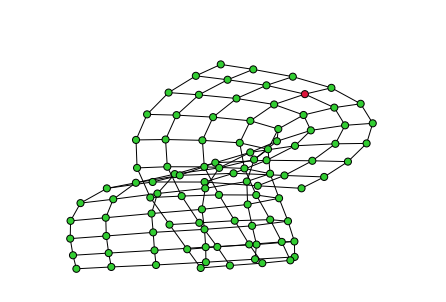

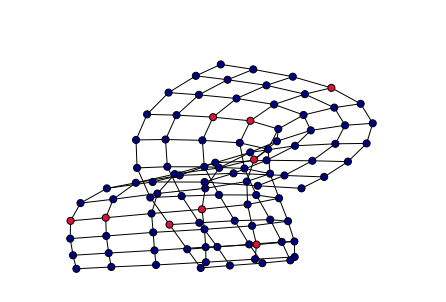

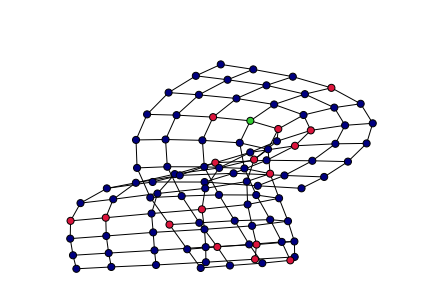

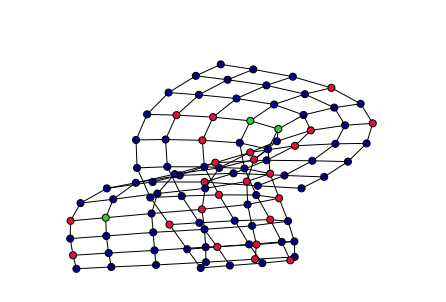

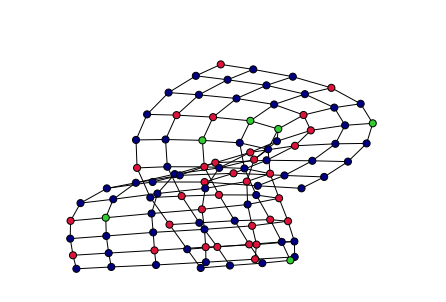

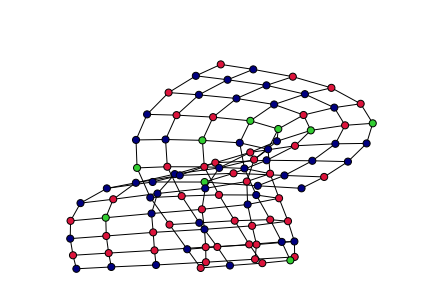

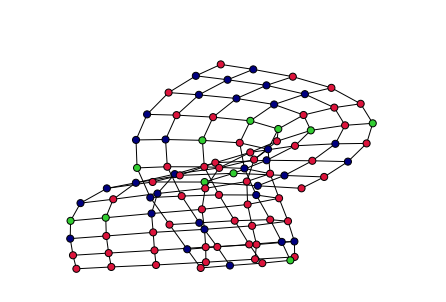

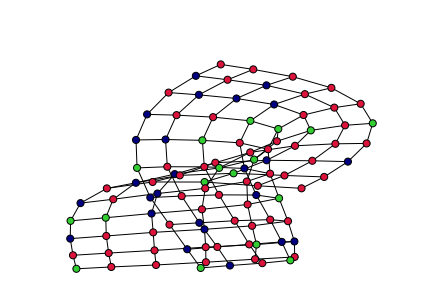

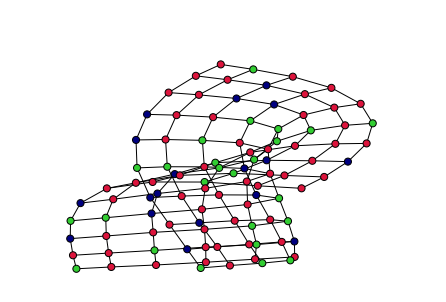

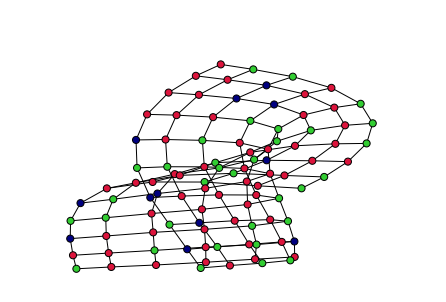

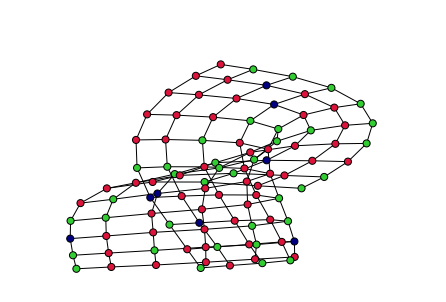

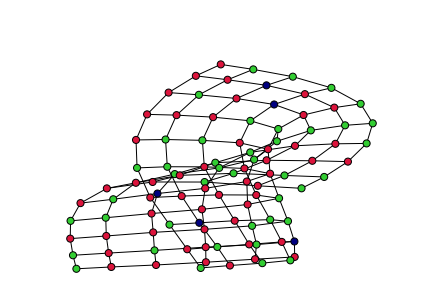

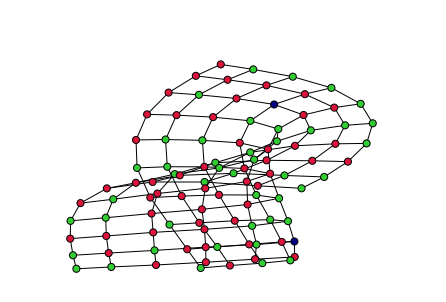

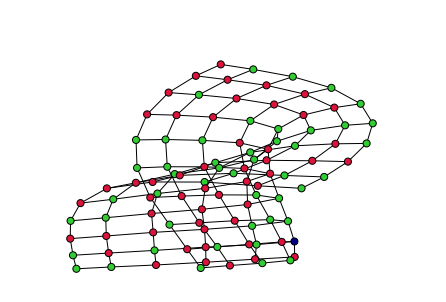

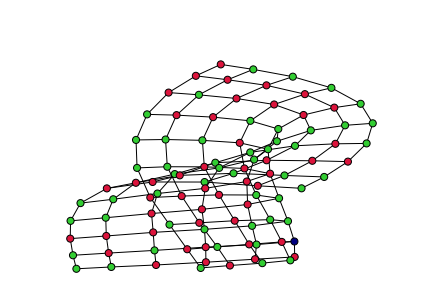

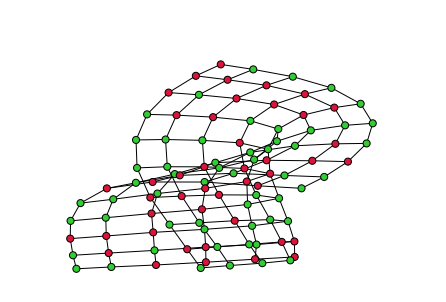

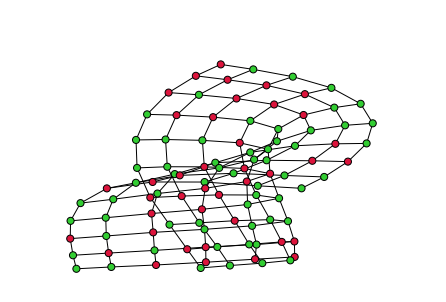

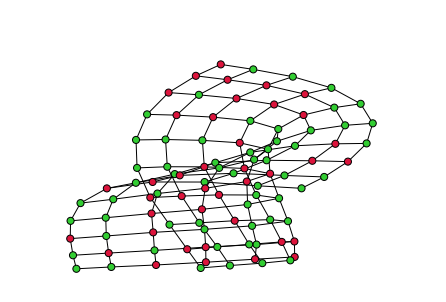

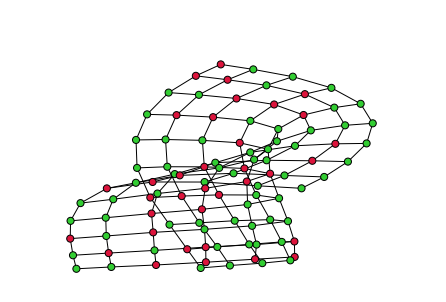

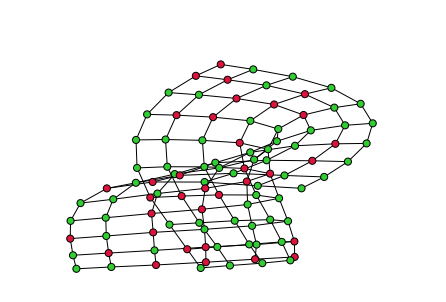

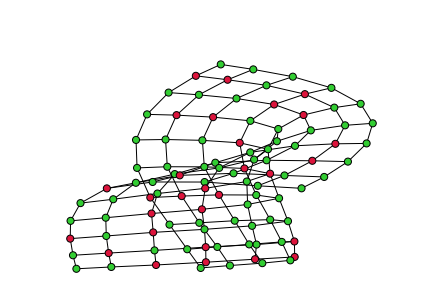

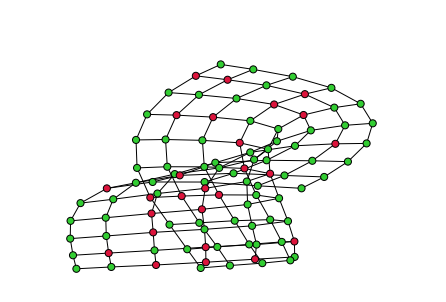

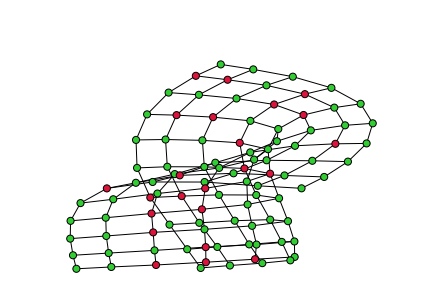

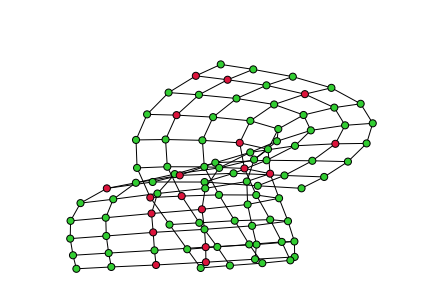

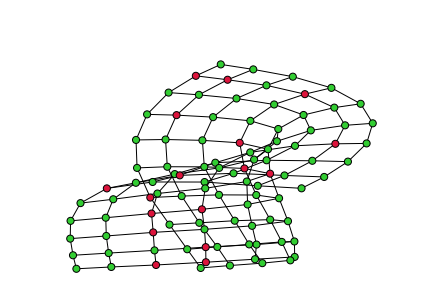

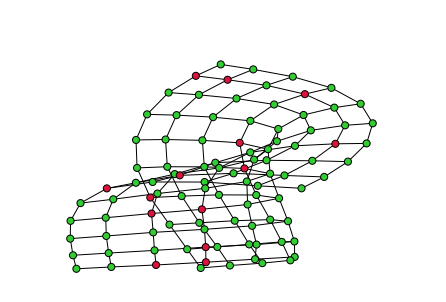

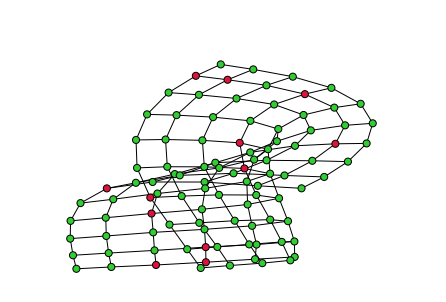

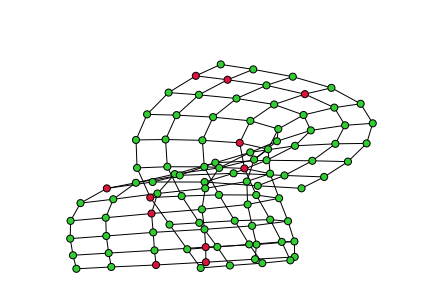

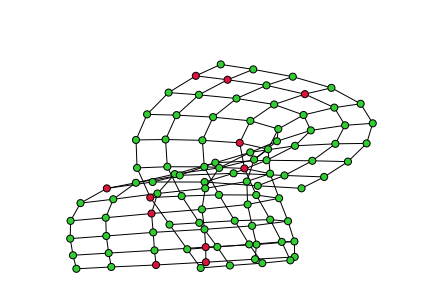

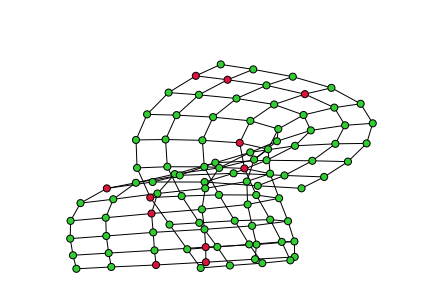

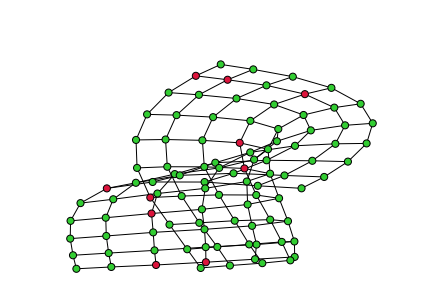

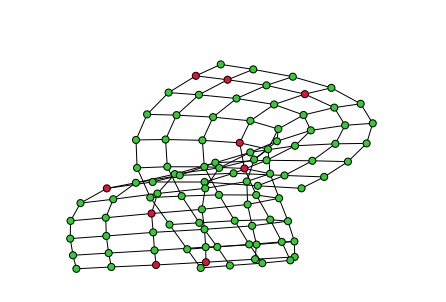

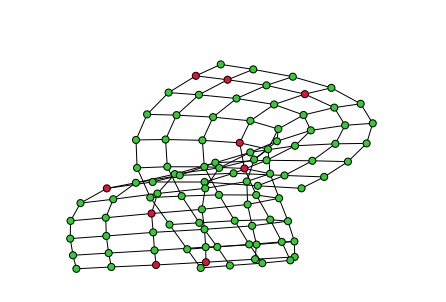

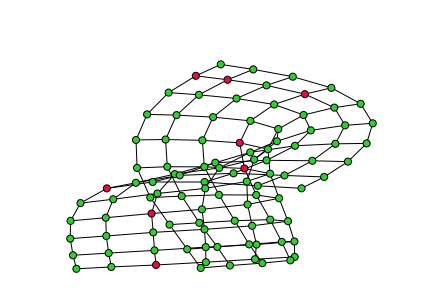

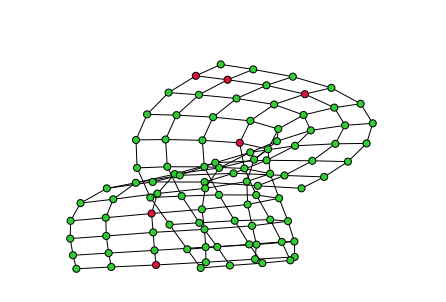

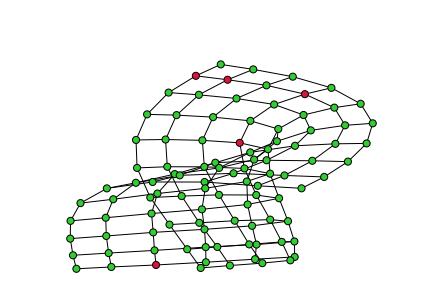

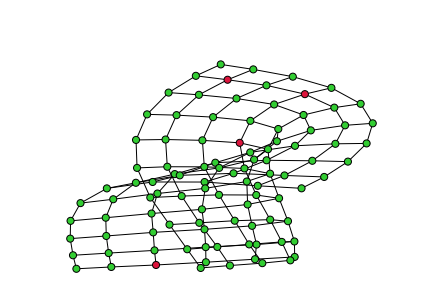

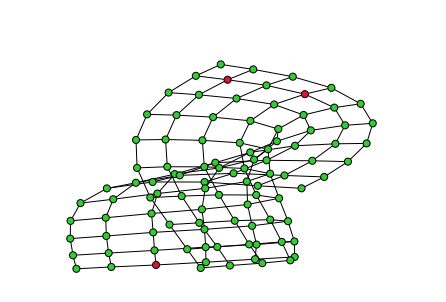

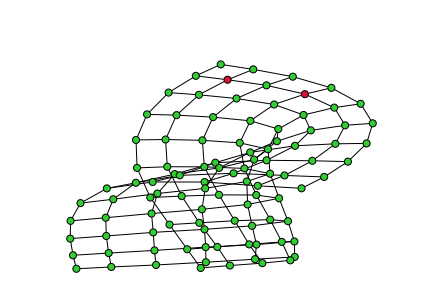

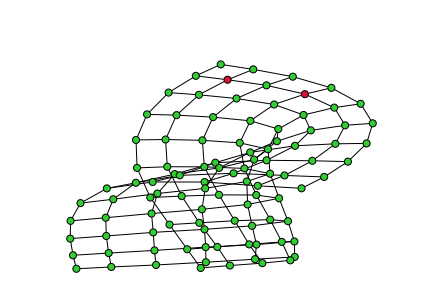

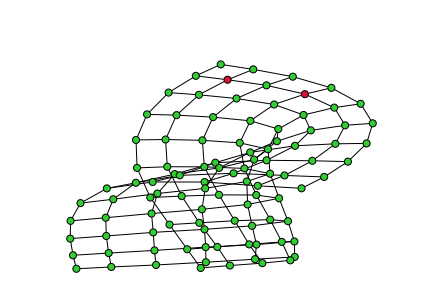

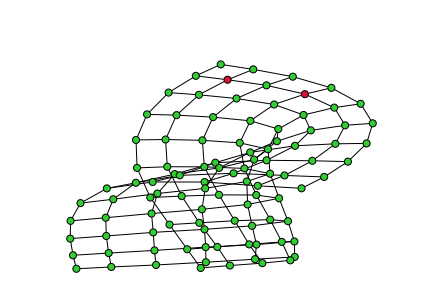

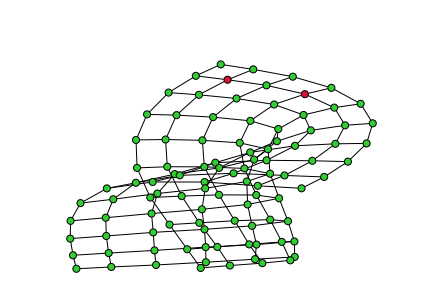

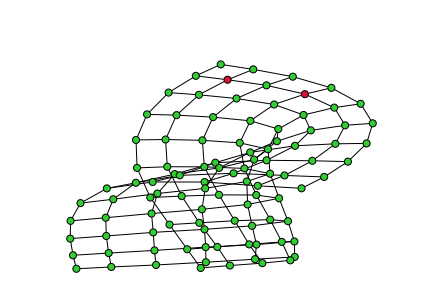

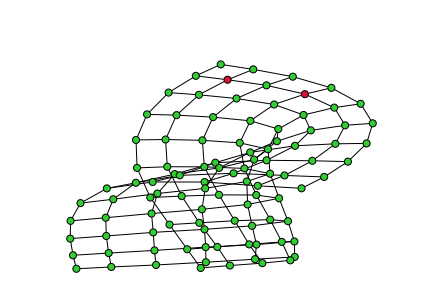

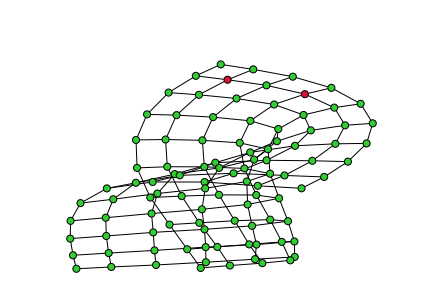

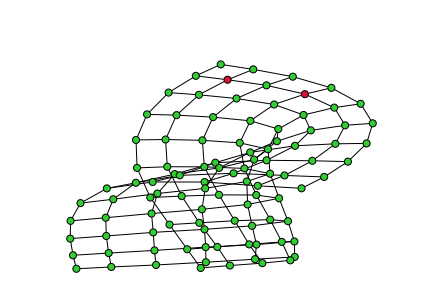

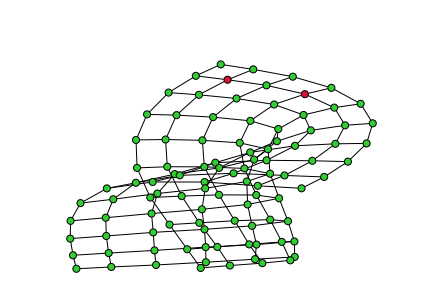

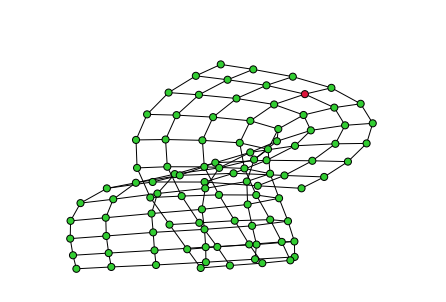

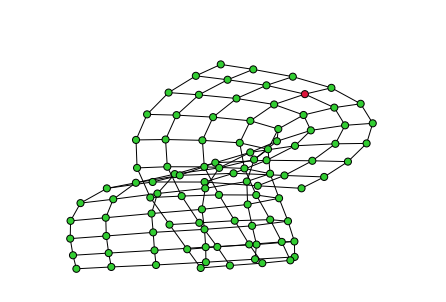

In [ ]:
S_size, I_size, R_size = run_MC_SIR( G, all_people, N, max_iter, beta_val, gamma_val, colors_dict, True )

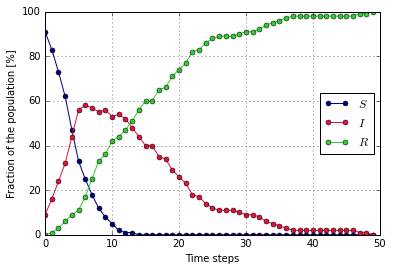

In [ ]:
draw_timeline( S_size, I_size, R_size, colors_dict )

### Average multiple simulations

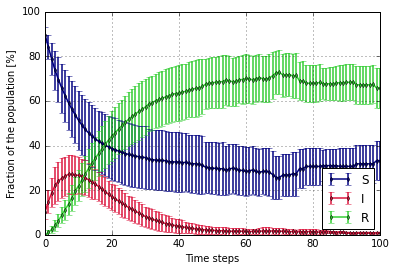

In [ ]:
name_states = ['S', 'I', 'R']
colors_dict = { 'S' : 'navy', 'I' : 'crimson', 'R' : 'limegreen' }
max_iter = 100
N = 100
beta_val = 0.3 # Infection rate
gamma_val = 0.1 # Recovery rate
num_simulations = 100

all_results_S = []
all_results_I = []
all_results_R = []
for each_sim in range(num_simulations):
    all_people = []
    for i in range( N ):
        all_people.append( SomePerson( np.random.choice(
                                        name_states, p = [0.9, 0.1, 0.0] ) ) )

    G = nx.connected_watts_strogatz_graph( N, 3, 0.4 )

    S_size, I_size, R_size = run_MC_SIR( G, all_people, N, max_iter, beta_val, gamma_val, colors_dict, False )
    
    all_results_S.append( S_size )
    all_results_I.append( I_size )
    all_results_R.append( R_size )
    
    
plot_errorbars( all_results_S, all_results_I, all_results_R, colors_dict )